In [2]:
!pip install -U scikit-learn


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 103.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [ ]:
!pip install imodelsx

# Tree Prompting: Efficient Task Adaptation without Fine-Tuning

Tree Prompting, a method for leveraging decision trees to improve the accuracy of language models (LMs) without fine-tuning. By constructing decision trees with LM prompts at each node, this approach utilizes training data effectively and maintains interpretability. Experiments on classification tasks demonstrate that Tree Prompting enhances performance compared to traditional few-shot prompting and is competitive with fine-tuning, offering a promising strategy for efficient task adaptation in memory-constrained environments.

The original article is [here](https://arxiv.org/pdf/2310.14034), the code is from [here](https://github.com/csinva/imodelsX/blob/master/demo_notebooks/tree_prompt.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2
from imodelsx import TreePromptClassifier
import datasets
import numpy as np
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

In [2]:
# set up data
rng = np.random.default_rng(seed=42)
dset_train = datasets.load_dataset('rotten_tomatoes')['train']
dset_train = dset_train.select(rng.choice(
    len(dset_train), size=100, replace=False))
dset_val = datasets.load_dataset('rotten_tomatoes')['validation']
dset_val = dset_val.select(rng.choice(
    len(dset_val), size=100, replace=False))

# set up arguments
# template for the prompt, for different prompt styles (e.g. few-shot), may want to place {prompt} before {example}
# or you may want to add some text before the verbalizer, e.g. {example}{prompt} Output:
prompt_template = "{example}{prompt}"
prompts = [
    " This movie is",
    " Positive or Negative? The movie was",
    " The sentiment of the movie was",
    " The plot of the movie was really",
    " The acting in the movie was",
]
verbalizer = {0: " Negative.", 1: " Positive."}
checkpoint = "gpt2"

# extract prompt outputs and fit decision tree of prompts
m = TreePromptClassifier(
    checkpoint=checkpoint,
    prompts=prompts,
    verbalizer=verbalizer,
    prompt_template=prompt_template,
    # cache_prompt_features_dir='cached_prompt_features',
    # cache_key_values=False,
)
m.fit(dset_train["text"], dset_train["label"])


# compute accuracy
print('Predicting on validation set...')
preds = m.predict(dset_val['text'])
print('\nTree-Prompt acc (val) ->',
      np.mean(preds == dset_val['label']))

# compare to accuracy for individual prompts
for i, prompt in enumerate(prompts):
    print(i, prompt, '->', m.prompt_accs_[i])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Prompt 0:  This movie is


Prompt 1:  Positive or Negative? The movie was


Prompt 2:  The sentiment of the movie was


Prompt 3:  The plot of the movie was really


Prompt 4:  The acting in the movie was


Predicting on validation set...
Prompt 0:  This movie is


Prompt 1:  The plot of the movie was really



Tree-Prompt acc (val) -> 0.7
0  This movie is -> 0.63
1  Positive or Negative? The movie was -> 0.5
2  The sentiment of the movie was -> 0.5
3  The plot of the movie was really -> 0.58
4  The acting in the movie was -> 0.51


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


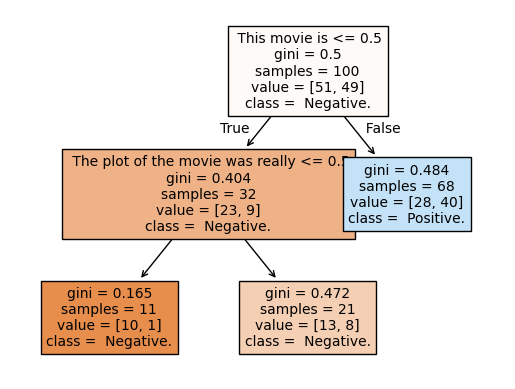

In [3]:
# visualize decision tree
plot_tree(
    m.clf_,
    fontsize=10,
    feature_names=m.feature_names_,
    class_names=list(verbalizer.values()),
    filled=True,
)
plt.show()